<h1> Do the presence of certain venues increase the spread of Covid-19 </h1>

<h3> Introduction/Background </h3>

In this project I would like to look at how the social environment may effect the spread of Covid-19. This project will primarly look at different venue types and their potential affect on Covid-19 spread. We know that social-distancing is important to help prevent the spread of covid-19 and we also know that certain business venues allow for different levels of distancing. For example, the purpose of a bar is to interact with other persons, so even while "practicing" social distancing, a bar is probably more likely to spread Covid-19 verus a venue where the primary purpose isn't interaction; e.g. a grocery store. All of the different zipcode areas within Manhattan and their surrounding venues in comparrison with Covid-19 death rates will be used as the subject of this project.


<h3> Reasoning/Assumptions </h3>

The <b>'reservations'</b> section will discuss why our assumptions are likely invalid.

* We specifically chose to only include Manhattan instead of all of New York City (or the other parts of country) to try and limit the geographical effect on viral transmission within this project. 

* We have used up to date death rates even though the effect of venue presence would have been muted once lockdowns were put into place. We assume that the original damedge was done early before lockdowns were put into place and that the current death rates are a carry forward effect from when the venues were still open.

* We have used death rate instead of case rate because of the amount of cases that go unreported. We assume it is much less likely to fail to report/attribute a death, than it is to fail to report a case (e.g. someone is assymtomatic and never gets tested.)

<h3> Data Collection </h3>

The following github link was used to gather Manhattan zipcode data as well as the associated death rates for those areas:

https://github.com/nychealth/coronavirus-data/blob/master/data-by-modzcta.csv

We also needed data for the venues which surround each zipcode area. To get this data we used the FourSquare.com explore endpoint API. The API returns a category for each venue so that two differently named bars will both return as "bar". This allows us to group the prevenelce of each venue type to each area.

<h3> Modeling </h3>

There will be two different types of models eployed. The first will be a Multiple Linear Regression model to try and estimate the covid-19 death rate based off of the data set. We do not expect this model to perform well for reasons which are listed under the <b>'reservations'</b> section.

The second model will use K-Means to cluster similar zipcode regions based entirely off of venue type. We will then compare the average death rate against the different clusters to see if there is a difference between clusters. ANOVA may be a suitable test to check if there is a significant difference of means. I would like to add that this model will also come with many reservations which will be listed in the 'reservations' section.

<h3> Purpose and Use </h3>

The purpose of this model is to see if the presence of certain venues lead to an increase covid-19 transmission. If it were possible to make such a determination, that information would be very valuable to government officials deciding how to re-open their economies. 

<h3> Reservations/Issues </h3>

* People who die within one zip code area may have been originally infected from a venue in a different area.

* Certain venues may attract different demographics. It is these demographics which may more likely be the root instead of the venues themselves. For example bars may attract young people so an area with a lot of bars might have a demographically lower median age which could lead to less deaths. On the other side of that argument, certain venues may attract demographics that are more/less likely to practice proper social distancing.

* One population center may be more likely to have increased death rates if it is adjecent to another area with high death rates regardless of which venues it contains.

* The data fails to look at: population density of different areas; venue density; or venue count. <b>It rather only identifies venue prevelence relative to its own area</b>.



<h3> Imports </h3>

In [115]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

ModuleNotFoundError: No module named 'folium'

<h3> Beautiful Soup used to scrap data</h3>

In [116]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request

url = 'https://github.com/nychealth/coronavirus-data/blob/master/data-by-modzcta.csv'
fp = urllib.request.urlopen(url)
mybytes = fp.read()

mystr = mybytes.decode("utf8")
fp.close()
soup = BeautifulSoup(mystr, 'html.parser')

table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
df=df[0]
df = df[df['BOROUGH_GROUP']== 'Manhattan']
df1 = df[['NEIGHBORHOOD_NAME','MODIFIED_ZCTA','COVID_DEATH_RATE']]
df1.head()

,NEIGHBORHOOD_NAME,MODIFIED_ZCTA,COVID_DEATH_RATE
0,Chelsea/NoMad/West Chelsea,10001,97.61
1,Chinatown/Lower East Side,10002,200.64
2,East Village/Gramercy/Greenwich Village,10003,61.34
3,Financial District,10004,27.39
4,Financial District,10005,23.82


<h3> FourSquare API Explore endpoint used to collect venue data associated with zipcode areas</h3>

In [117]:
CLIENT_ID = 'VI1AEMLO03KXWQOYOSRPBFFT40HJOQ1ZYFXUC2HFJXUVAAUC' # your Foursquare ID
CLIENT_SECRET = 'MALO04YAJ1XF3JBRX4TSBHKQJTDYMQOCJMGQOEW3XA0GWOOJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100
def getNearbyVenues(names, zipcode, radius=250):
    
    venues_list=[]
    for name, zipcode in zip(names, zipcode):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            zipcode, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            zipcode, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'zipcode',
                  'Venue Name',
                  'Lat coord',
                  'Long coord',
                  'Venue Category']
    
    return(nearby_venues)


Your credentails:
CLIENT_ID: VI1AEMLO03KXWQOYOSRPBFFT40HJOQ1ZYFXUC2HFJXUVAAUC
CLIENT_SECRET:MALO04YAJ1XF3JBRX4TSBHKQJTDYMQOCJMGQOEW3XA0GWOOJ


In [118]:
manhattan_venues = getNearbyVenues(names=df1['NEIGHBORHOOD_NAME'],
                                   zipcode=df1['MODIFIED_ZCTA'],
                                  )

Chelsea/NoMad/West Chelsea
Chinatown/Lower East Side
East Village/Gramercy/Greenwich Village
Financial District
Financial District
Financial District
TriBeCa
Alphabet City/East Village/Stuyvesant Town-Cooper Village
Flatiron/Gramercy/Kips Bay
Chelsea
Greenwich Village/SoHo
Hudson Square/Little Italy/SoHo/TriBeCa
Hudson Square/Meatpacking District/West Village
Kips Bay/Murray Hill/NoMad
East Midtown/Murray Hill
Hell's Kitchen/Midtown Manhattan
Hell's Kitchen/Midtown Manhattan
Lenox Hill/Upper East Side
East Midtown
Lincoln Square
Upper West Side
Manhattan Valley/Morningside Heights/Upper West Side
Central Harlem (South)
Central Harlem (South)/Morningside Heights/West Harlem
Upper East Side/Yorkville
East Harlem
Central Harlem (North)
Hamilton Heights/West Harlem
Washington Heights (South)
Washington Heights (North)/Washington Heights (South)
Inwood/Washington Heights (North)
East Harlem
Hell's Kitchen/Midtown Manhattan
Central Harlem (North)/East Harlem
Chinatown/Financial District
Cent

In [119]:
manhattan_venues.head()
manhattan_venues.groupby('zipcode').count()

,Neighborhood,Venue Name,Lat coord,Long coord,Venue Category
zipcode,,,,,
10001,39,39,39,39,39
10002,36,36,36,36,36
10003,23,23,23,23,23
10004,8,8,8,8,8
10005,53,53,53,53,53
10006,37,37,37,37,37
10007,40,40,40,40,40
10009,35,35,35,35,35
10010,31,31,31,31,31


In [120]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['zipcode'] = manhattan_venues['zipcode'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('zipcode').mean().reset_index()

<h3> Merging data sets together. This is all of the data which will be used for the rest of the project.</h3>

In [137]:
final_data = manhattan_grouped.merge(df1,left_on='zipcode',right_on='MODIFIED_ZCTA',how='inner')
final_data.head()

,zipcode,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Rest Area,Restaurant,River,Rock Climbing Spot,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Snack Place,Soba Restaurant,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,NEIGHBORHOOD_NAME,MODIFIED_ZCTA,COVID_DEATH_RATE
0,10001,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.025641,0.0,0.000000,0.000000,0.051282,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0000

<h3> Multiple Linear Regression </h3>

In [138]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y_data = final_data['COVID_DEATH_RATE']
x_data = final_data.drop(columns = ['zipcode','NEIGHBORHOOD_NAME','MODIFIED_ZCTA','COVID_DEATH_RATE'])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=2)

regr = linear_model.LinearRegression()
regr.fit(x_train,y_train)
print('The shape of the input data is {}'.format(x_train.shape))
print('The R^2 value for the MLR is {}'.format(regr.score(x_test,y_test).round(2)))

The shape of the input data is (33, 249)
The R^2 value for the MLR is -0.22


<h3> First Impression </h3>
This model performs very bad. There could be a couple of reasons for this which I can think of:

* There are not nearly enough data points. Currently there are about 250 fields but only about 40 data points
* The target variable is not explained by the effect variables (e.g. Venues are not predictors of Covid Spread Rate)

Also note that a negative 'score' is possible. A negative score indicates that the model does a worse job of predicting the target versus simply using the mean of the target as the predicted value.

<h3> Reduce number of fields</h3>

In [139]:
tempdf = x_data.mean(axis=0)
tempdf = tempdf[tempdf>.01]
col_names = tempdf.index
Xnew = x_data[col_names]
Xnew.shape # number of feilds reduced by approx a factor of 10

(44, 28)

In [140]:
x_train, x_test, y_train, y_test = train_test_split(Xnew, y_data, test_size=0.25, random_state=2)

regr = linear_model.LinearRegression()
regr.fit(x_train,y_train)
print('The shape of the input data is {}'.format(x_train.shape))
print('The R^2 value for the MLR is {}'.format(regr.score(x_test,y_test).round(2)))

The shape of the input data is (33, 28)
The R^2 value for the MLR is -2.08


<h3> MLR Conclusion </h3>

After reducing the number of fields, the MLR model performed worse

<h3>K-Means</h3>
In this section we will cluster together the different zipcode areas and label them. We will then take the average covid death rate for each cluster and see if the cluster means are significantly different


Number of clusters = 1 and score = 10955.999999999993
Number of clusters = 2 and score = 10447.548979960602
Number of clusters = 3 and score = 10068.781435850431
Number of clusters = 4 and score = 9736.763396396651
Number of clusters = 5 and score = 9271.781034171338
Number of clusters = 6 and score = 8917.298556253632
Number of clusters = 7 and score = 8608.862212499216
Number of clusters = 8 and score = 8182.487171712671
Number of clusters = 9 and score = 7864.066357895817


Text(0, 0.5, 'MCSS')

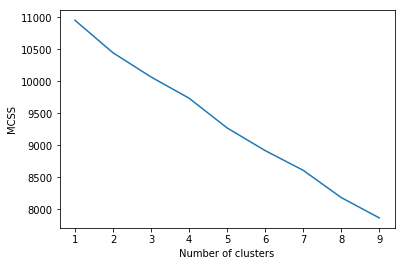

In [141]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

cluster_dataset = StandardScaler().fit_transform(x_data)
def runKmeans(x,n):
    inertia = []
    for i in range(n):
        k_means = KMeans(init="k-means++", n_clusters= (i+1), n_init=25)
        k_means.fit(x)
        print('Number of clusters = {} and score = {}'.format((i+1),k_means.inertia_))
        inertia += [k_means.inertia_]
    return inertia


y = runKmeans(cluster_dataset,9)
plt.plot([1,2,3,4,5,6,7,8,9],y)
plt.xlabel('Number of clusters')
plt.ylabel('MCSS')

<h3> Optimal K </h3>
There is a slight kink in the chart around k = 6 so we will use three clusters in our kMeans model. Using k = 4 is another option. The scoring method used is 'inertia_' which is the sum of the within cluster sum of sqaures (WCSS). 

In [143]:
from sklearn.preprocessing import StandardScaler

cluster_dataset = StandardScaler().fit_transform(x_data)
k_means = KMeans(init="k-means++", n_clusters=6, n_init=25)
k_means.fit(cluster_dataset)
labels = k_means.labels_
final_data['labels']=labels
final_data

,zipcode,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Rest Area,Restaurant,River,Rock Climbing Spot,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Snack Place,Soba Restaurant,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,NEIGHBORHOOD_NAME,MODIFIED_ZCTA,COVID_DEATH_RATE,labels
0,10001,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [145]:
final_data.groupby(['labels']).count()


,zipcode,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Rest Area,Restaurant,River,Rock Climbing Spot,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Snack Place,Soba Restaurant,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,NEIGHBORHOOD_NAME,MODIFIED_ZCTA,COVID_DEATH_RATE
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,

In [150]:
final_data.groupby(['labels']).mean()



,zipcode,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Rest Area,Restaurant,River,Rock Climbing Spot,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Snack Place,Soba Restaurant,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,MODIFIED_ZCTA,COVID_DEATH_RATE
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10031.000000,0.004762,0.000000,0.00000,0.010811,0.000000,0.004762,0.000000,0.008333,0.000000,0.000000,0

<h3>K-Means Conclusion</h3>
There are 3 groups with multiple areas and three groups each with one area.

The three main groups are as follows:

Cluster 0 Death Rate = 209.25<br>
Cluster 1 Death Rate = 131.27<br>
Cluster 5 Death Rate = 112.18

The other three clusters range from 37.53 to 77.31


This may be worth looking further into although nothing conclusive can be determined from this information alone.

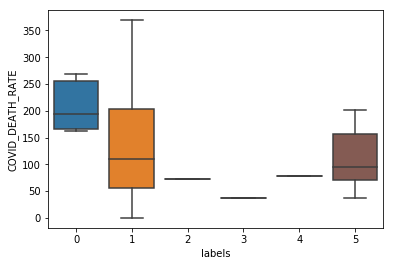

In [152]:
import seaborn as sns
sns.boxplot(x = final_data['labels'],y = final_data['COVID_DEATH_RATE'])

In [161]:
df0 = final_data[final_data['labels']==0]
df0 = df0[['COVID_DEATH_RATE']]
df1 = final_data[final_data['labels']==1]
df1 = df0[['COVID_DEATH_RATE']]
df5 = final_data[final_data['labels']==5]
df5 = df0[['COVID_DEATH_RATE']]
print(df0)

stats.f_oneway(df0['COVID_DEATH_RATE'],df1['COVID_DEATH_RATE'],df5['COVID_DEATH_RATE'])

    COVID_DEATH_RATE
23            165.01
25            256.21
28            268.33
29            194.22
30            162.51


F_onewayResult(statistic=1.1407122796748182e-45, pvalue=1.0)

<h3> ANOVA Conclusion </h3>

The p-value for ANOVA is 1 which means that there is no statistical difference amongst clusters in terms of Covid Death Rate.<br>

We conclude that the types/categories within an area do not have an effect on the spread of Covid-19